# Connecting to MIMIC

I took the following from https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/tutorials/cohort-selection.ipynb

What I have done was download the data to my local home server (it was very slow, took about 5 hours). I then used the repository I linked above and converted the csv files into a postgres database, which I can now access locally!

The below works on my machine when running the database:

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, password="postgres")

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'


In [2]:
query = query_schema + """
SELECT subject_id, hadm_id, icustay_id
FROM icustays
LIMIT 100
"""
df = pd.read_sql_query(query, con)
df.head(10)

/tmp/ipykernel_71633/4282104791.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con)


,subject_id,hadm_id,icustay_id
0,268,110404,280836
1,269,106296,206613
2,270,188028,220345
3,271,173727,249196
4,272,164716,210407
5,273,158689,241507
6,274,130546,254851
7,275,129886,219649
8,276,135156,206327
9,277,171601,272866


In [3]:
query = query_schema + """
SELECT itemid, label
FROM d_items
ORDER BY itemid;
"""

itemids = pd.read_sql_query(query, con)
itemids.head(100)

/tmp/ipykernel_71633/3884238648.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  itemids = pd.read_sql_query(query, con)


,itemid,label
0,1,% Inspir. Time
1,2,ABI (L)
2,3,ABI (R)
3,4,ABI Ankle BP [Right]
4,5,ABI Brachial BP [Right]
...,...,...
95,117,Catheter Insert Date
96,118,Cerv Collar Status
97,119,Cervical Collar Type
98,121,Chest PT [Right]


# 5.1 "Surprising Distribution of Heart Rates"

In [17]:
heart_itemids = itemids[itemids['label'].str.contains("heart", case=False, na=False)]
# print(heart_itemids)

## Figure 2 Recreation

In [5]:
# looks like we want to include 211, 220045 ... and potentially 5972 (fetal heart rate)

In [6]:
# heart rates
query = query_schema + """
SELECT
    c.subject_id,
    c.hadm_id,
    c.icustay_id,
    c.charttime,
    c.value AS heart_rate,
    EXTRACT(YEAR FROM AGE(c.charttime, p.dob)) AS age -- Adjusted to prevent negative ages
FROM
    chartevents c
JOIN
    patients p ON c.subject_id = p.subject_id
WHERE
    c.itemid IN (220045, 211, 5972)  -- Include the specified item IDs
    AND c.value IS NOT NULL
ORDER BY
    c.charttime;

"""

heart = pd.read_sql_query(query, con)
heart.head(10)

/tmp/ipykernel_3499/920133899.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  heart = pd.read_sql_query(query, con)


,subject_id,hadm_id,icustay_id,charttime,heart_rate,age
0,82574,118464,202134.0,2100-06-08 00:18:00,68,56.0
1,82574,118464,202134.0,2100-06-08 01:00:00,59,56.0
2,82574,118464,202134.0,2100-06-08 02:00:00,58,56.0
3,82574,118464,202134.0,2100-06-08 02:30:00,60,56.0
4,82574,118464,202134.0,2100-06-08 02:44:00,69,56.0
5,82574,118464,202134.0,2100-06-08 02:45:00,63,56.0
6,82574,118464,202134.0,2100-06-08 03:00:00,60,56.0
7,82574,118464,202134.0,2100-06-08 03:15:00,61,56.0
8,82574,118464,202134.0,2100-06-08 03:30:00,60,56.0
9,82574,118464,202134.0,2100-06-08 04:00:00,60,56.0


In [7]:
heart.shape

(7923714, 6)

In [8]:
heart['heart_rate'] = pd.to_numeric(heart['heart_rate'], errors='coerce')

na_count = heart['heart_rate'].isnull().sum()
print("Number of NaN values in heart_rate:", na_count)

Number of NaN values in heart_rate: 0


In [9]:
mean_heart_rate = heart['heart_rate'].mean()
print("Mean Heart Rate:", mean_heart_rate)

Mean Heart Rate: 102.66196480034685


In [10]:
median_heart_rate = heart['heart_rate'].median()
print("Median Heart Rate:", median_heart_rate)

Median Heart Rate: 92.0


In [11]:
mean_age = heart['age'].mean()
print("Mean Age:", mean_age)

Mean Age: 57.427613995154296


In [12]:
median_age = heart['age'].median()
print("Median Age:", median_age)

Median Age: 60.0


In [13]:
min_age = heart['age'].min()
print("Min Age:", min_age)

Min Age: 0.0


In [14]:
max_age = heart['age'].max()
print("Max Age:", max_age)

Max Age: 310.0


Can we recreate figure 2 from section 5.1 now?

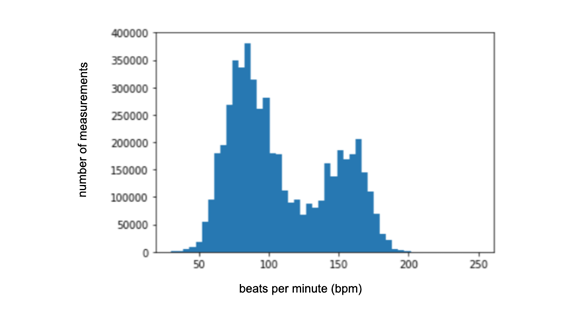

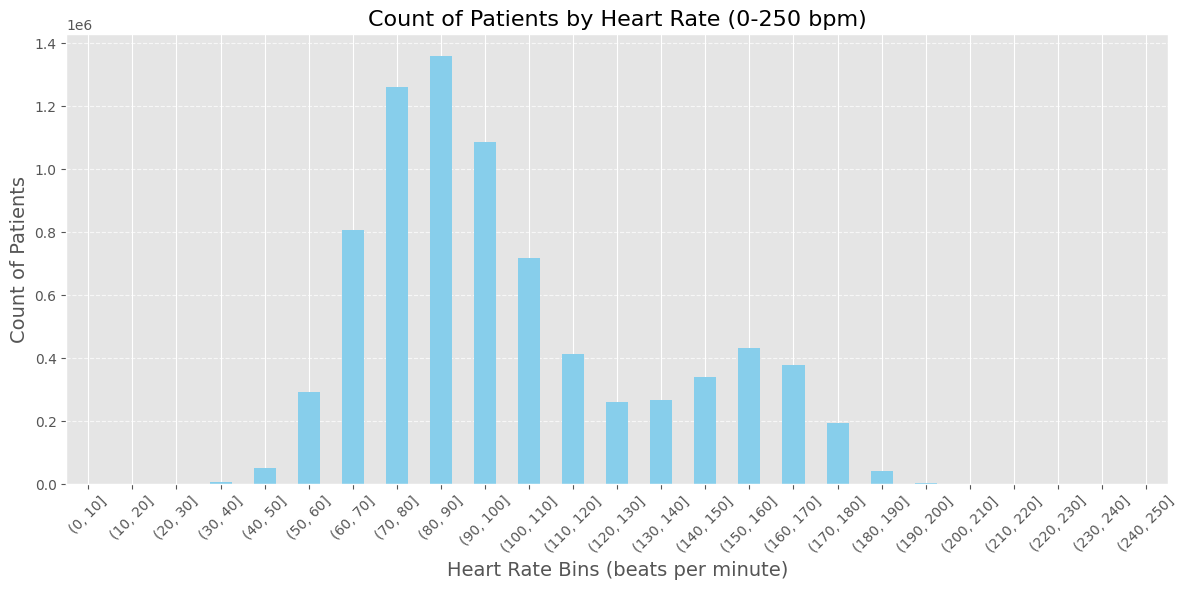

In [15]:
import matplotlib.pyplot as plt

heart = heart[(heart['heart_rate'] >= 0) & (heart['heart_rate'] <= 250)]

# Create bins for heart rate intervals (0-10, 10-20, ..., 240-250) I think this is what the image above is doing? 
bins = range(0, 260, 10)  # Bins from 0 to 250 in increments of 10
heart['heart_rate_bins'] = pd.cut(heart['heart_rate'], bins=bins)

# Count number of patients seen in each bin
heart_rate_histogram = heart['heart_rate_bins'].value_counts().sort_index()

plt.figure(figsize=(12, 6))  # Set the figure size
heart_rate_histogram.plot(kind='bar', color='skyblue')  # Bar plot
plt.xlabel('Heart Rate Bins (beats per minute)', fontsize=14)  # Label for x-axis
plt.ylabel('Count of Patients', fontsize=14)  # Label for y-axis
plt.title('Count of Patients by Heart Rate (0-250 bpm)', fontsize=16)  # Title of the chart

plt.xticks(rotation=45) 

plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show() 

Looks like we sort of have figure 2. I still want to confirm this with David.. the peaks line up, but the only thing that seems to be off is the total number of records. We max out around 1.4 million, while the figure 2 from the paper maxes out around 4 million. 

## Figure 3 Recreation

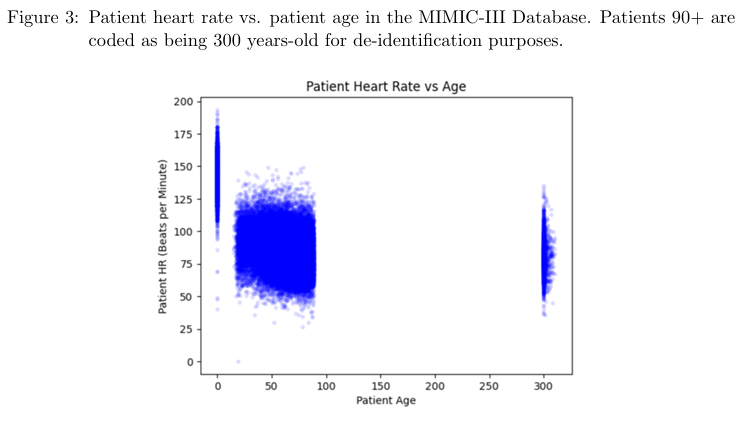

The purpose of this visual is two-fold (as described by the paper)
1. The difference in physiology of older humans and newborns is seen by the much higher heart rates seen around age 0
2. The giant gap in age from ~90 to 300. Why is this? The paper explains that all patients older than 90 are grouped together in a 300+ bin to avoid making it obvious who a person is based on their rare age

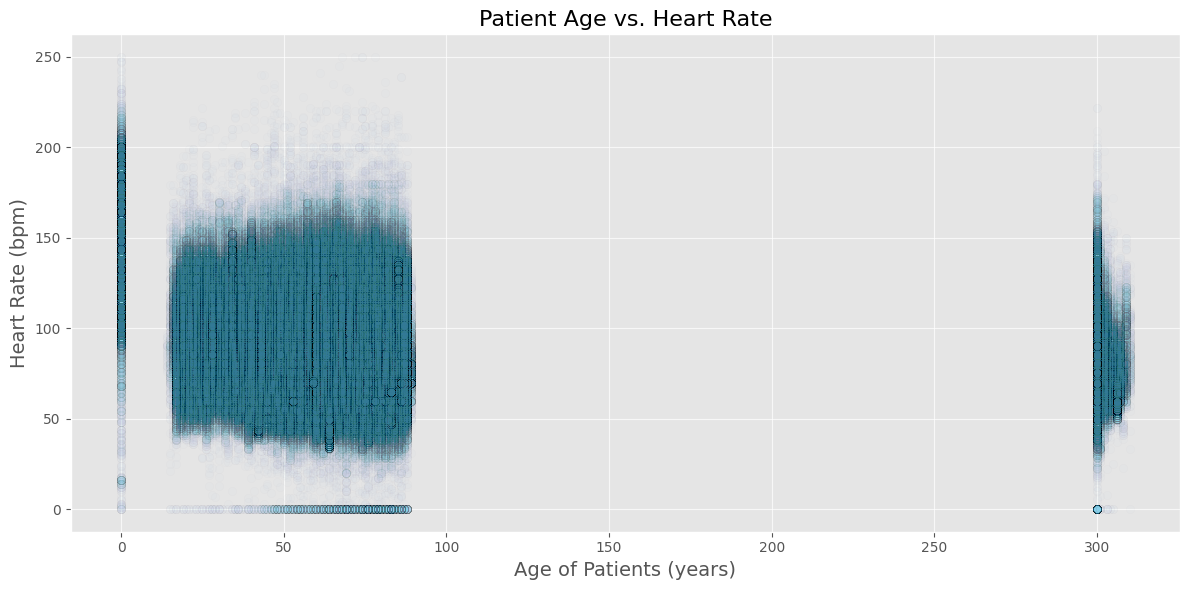

In [20]:
heart = heart[(heart['heart_rate'] >= 0) & (heart['heart_rate'] <= 250)]

plt.figure(figsize=(12, 6)) 

# Adjusting the alpha value for transparency; set lower value for more transparency
plt.scatter(heart['age'], heart['heart_rate'], alpha=0.01, color='skyblue', edgecolor='black')  

plt.xlabel('Age of Patients (years)', fontsize=14) 
plt.ylabel('Heart Rate (bpm)', fontsize=14)  
plt.title('Patient Age vs. Heart Rate', fontsize=16)  

plt.grid(alpha=0.7)  

plt.tight_layout()  
plt.show()  

Looks pretty close, don't you think? The key here is adjusting the alpha to make the dots really transparent since there is so much data that needs to fit on a single line. Not sure what is going on with the horizontal line there at the bottom.. maybe we should exclude all heart rates of 0 and chalk that up to improper measurements?